# [ARIMA 모델 기초](https://www.youtube.com/watch?v=rdR2fNDq6v0)

In [17]:
import os 

import pandas as pd 
import pandas_datareader.data as pdr 

from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score 

import matplotlib.pyplot as plt 
import matplotlib  
# plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
# from statsmodels.tsa.arima_model import ARIMA 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 

from pmdarima.arima import auto_arima 

import seaborn as sns 
# plt.style.use('seaborn-whitegrid')
# %matplotlib inline
plt.ion()

import itertools


# [Load AirPassengers Data](https://www.kaggle.com/datasets/rakannimer/air-passengers?resource=download)
- 1949년 ~ 1960년 매달 비행기 탑승객 수에 대한 시계열 데이터 

In [2]:
data = pd.read_csv('../data/AirPassengers.csv')
data.shape 

(144, 2)

In [3]:
data = data.rename(columns={'Month':'month', '#Passengers':'passengers'})
data['month'] = pd.to_datetime(data['month'])
data = data.set_index('month')
data 

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


# Box-Jenkins ARIMA Procedure

## Data Preprocessing

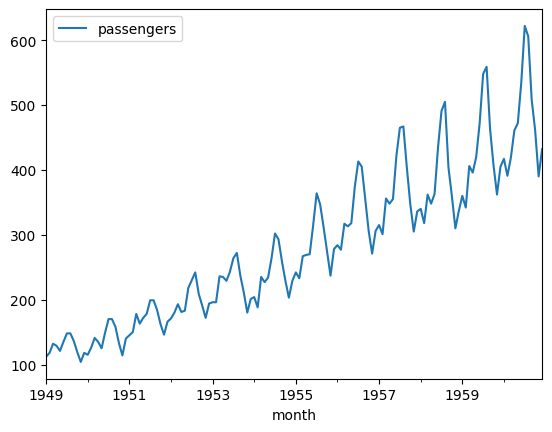

In [4]:
fig = data.plot()

- Seasonal decomposition plot: Seasonal decomposition using moving averages.
    - Observed: Observed data
    - Trend: The estimated trend component
    - Seasonal: The estimated seasonal component
    - resid: The estimated residuals

In [5]:
decompostion = sm.tsa.seasonal_decompose(data['passengers'], model='additive', period=1)
decompostion

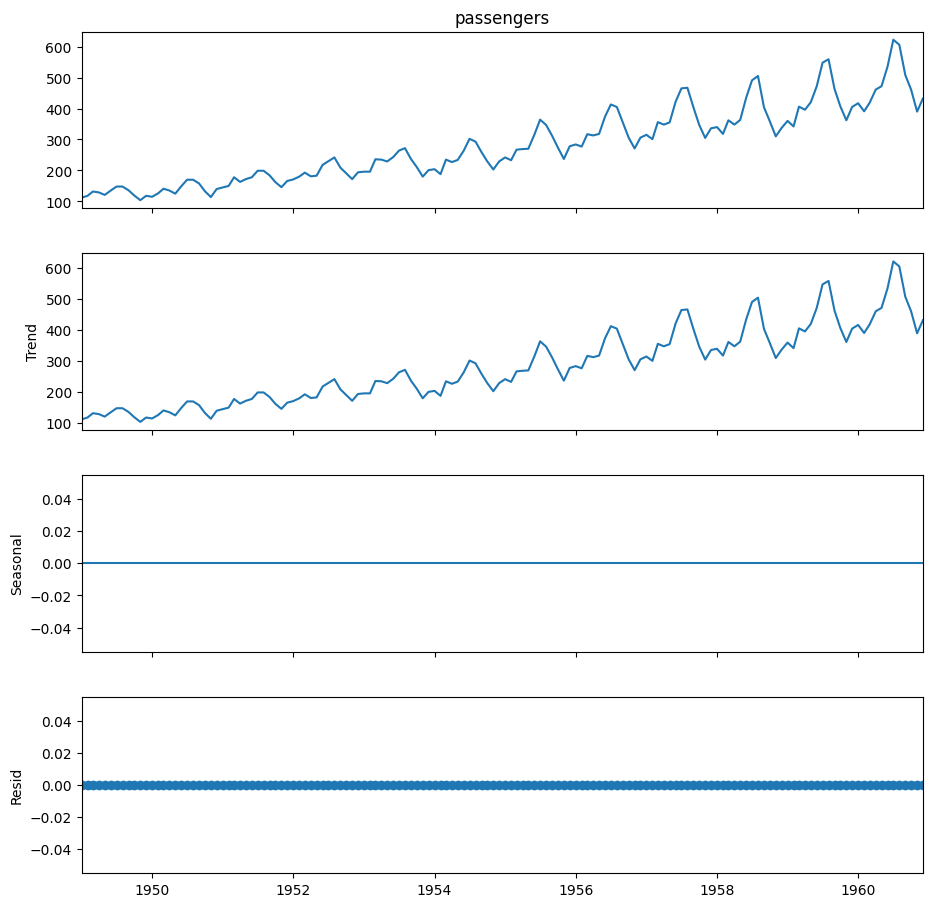

In [6]:
fig = decompostion.plot()
fig.set_size_inches(10,10)
plt.show()

## Identify Model to be Tentatively Entertainted

In [7]:
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

train_data.shape, test_data.shape 

((115, 1), (29, 1))

- ACF plot     
- PACF plot

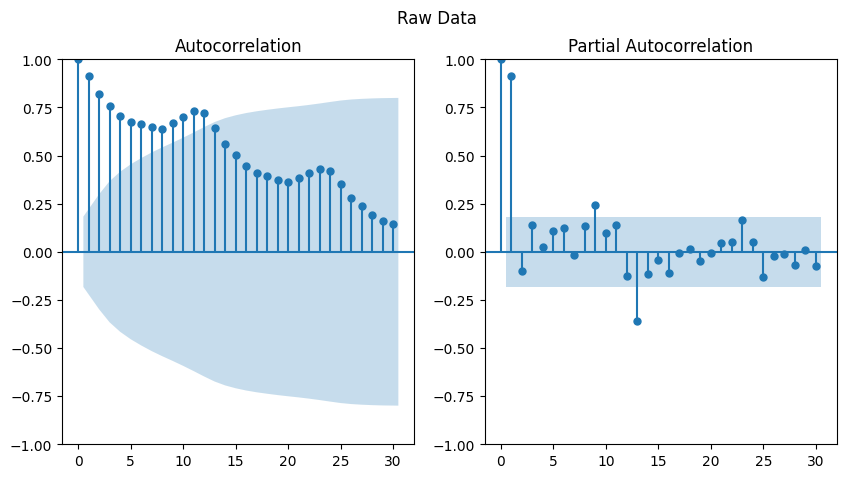

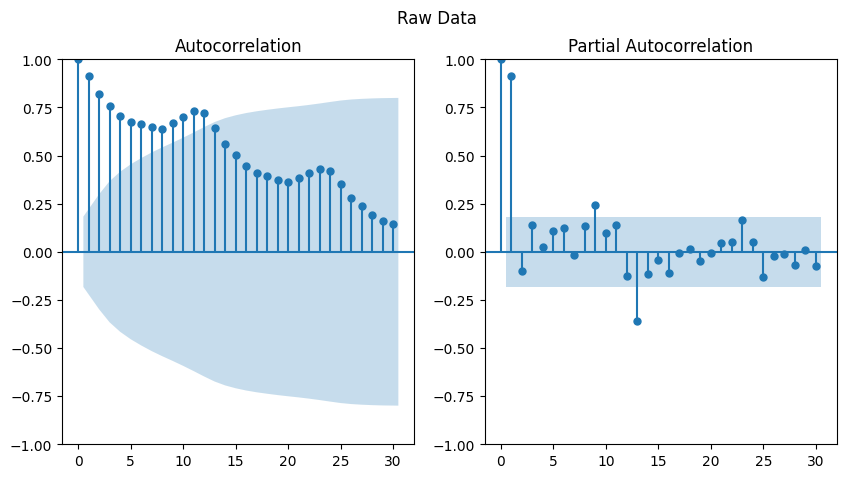

In [8]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Raw Data')

sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=30, ax=ax[1])

## Differencing

- 정상성(Stationarity) 없다는 것을 위의 그래프를 통해서 확인을 하였습니다.
- 그래서 차분(Differnecing)을 통해서 정상성이 있는 데이터로 보정을 할 예정입니다.

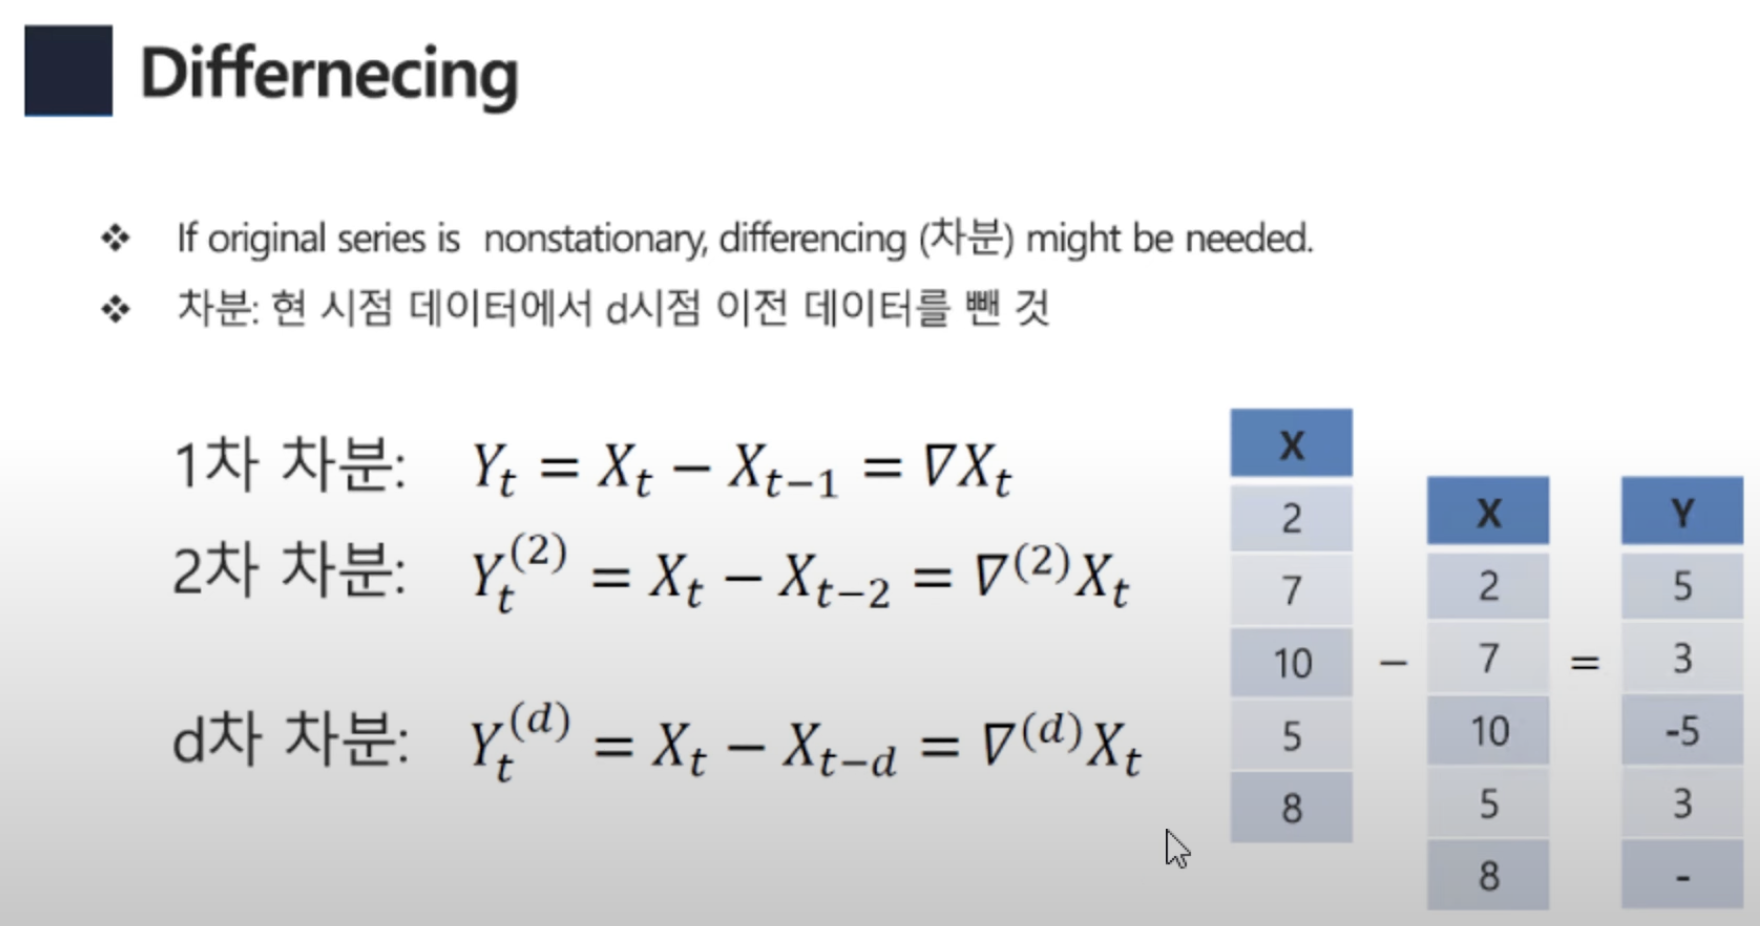

In [9]:
diff_train_data = train_data.copy()
diff_train_data = diff_train_data['passengers'].diff()
diff_train_data = diff_train_data.dropna()

print('########## Raw Data ##########')
print(train_data)

print('########## Differenced Data ##########')
print(diff_train_data)

########## Raw Data ##########
            passengers
month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1958-03-01         362
1958-04-01         348
1958-05-01         363
1958-06-01         435
1958-07-01         491

[115 rows x 1 columns]
########## Differenced Data ##########
month
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
1949-06-01    14.0
              ... 
1958-03-01    44.0
1958-04-01   -14.0
1958-05-01    15.0
1958-06-01    72.0
1958-07-01    56.0
Name: passengers, Length: 114, dtype: float64


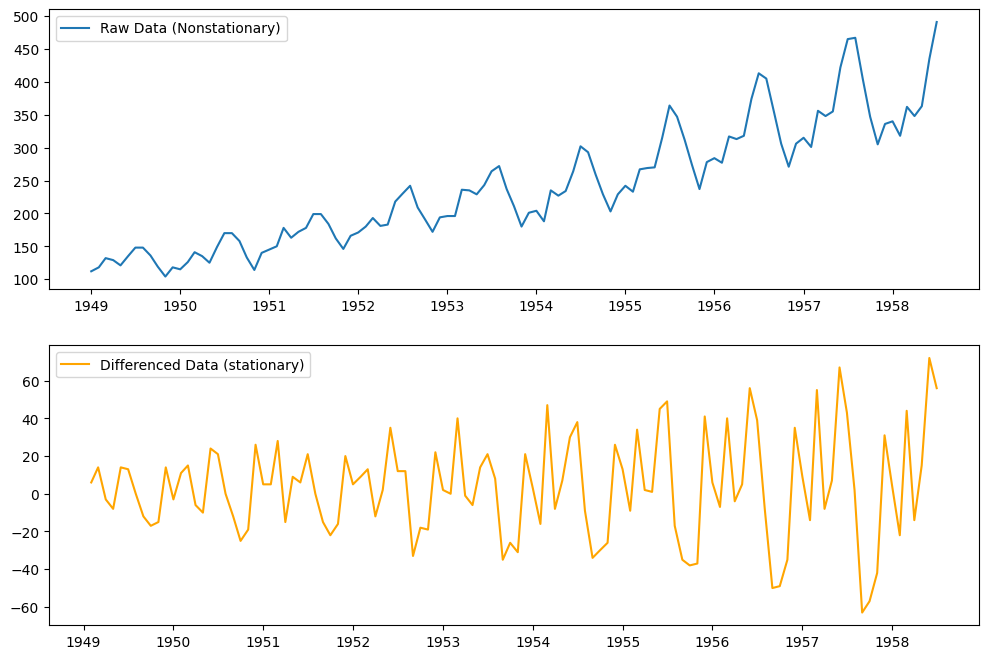

In [11]:
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(train_data['passengers'])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_train_data, 'orange')
plt.legend(['Differenced Data (stationary)'])
plt.show()

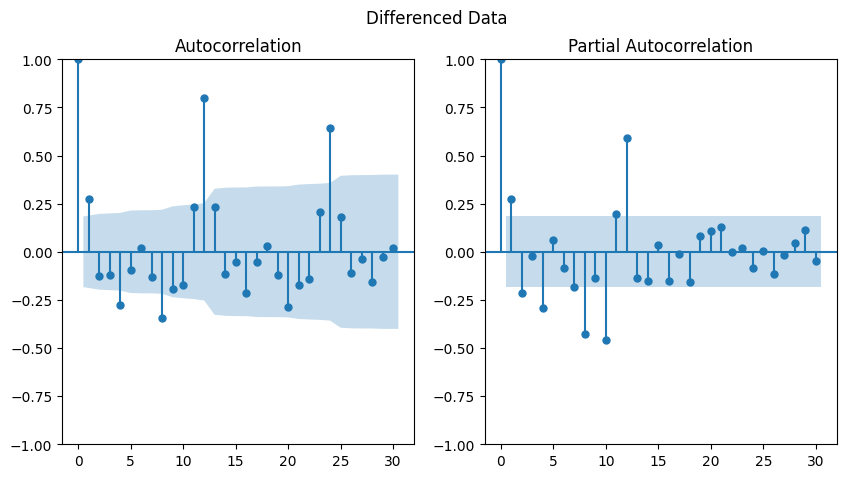

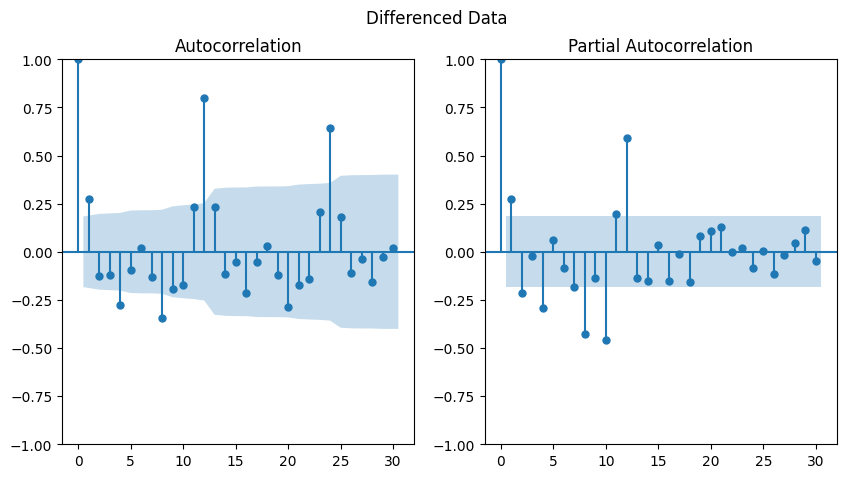

In [12]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Differenced Data')

sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=30, ax=ax[1])

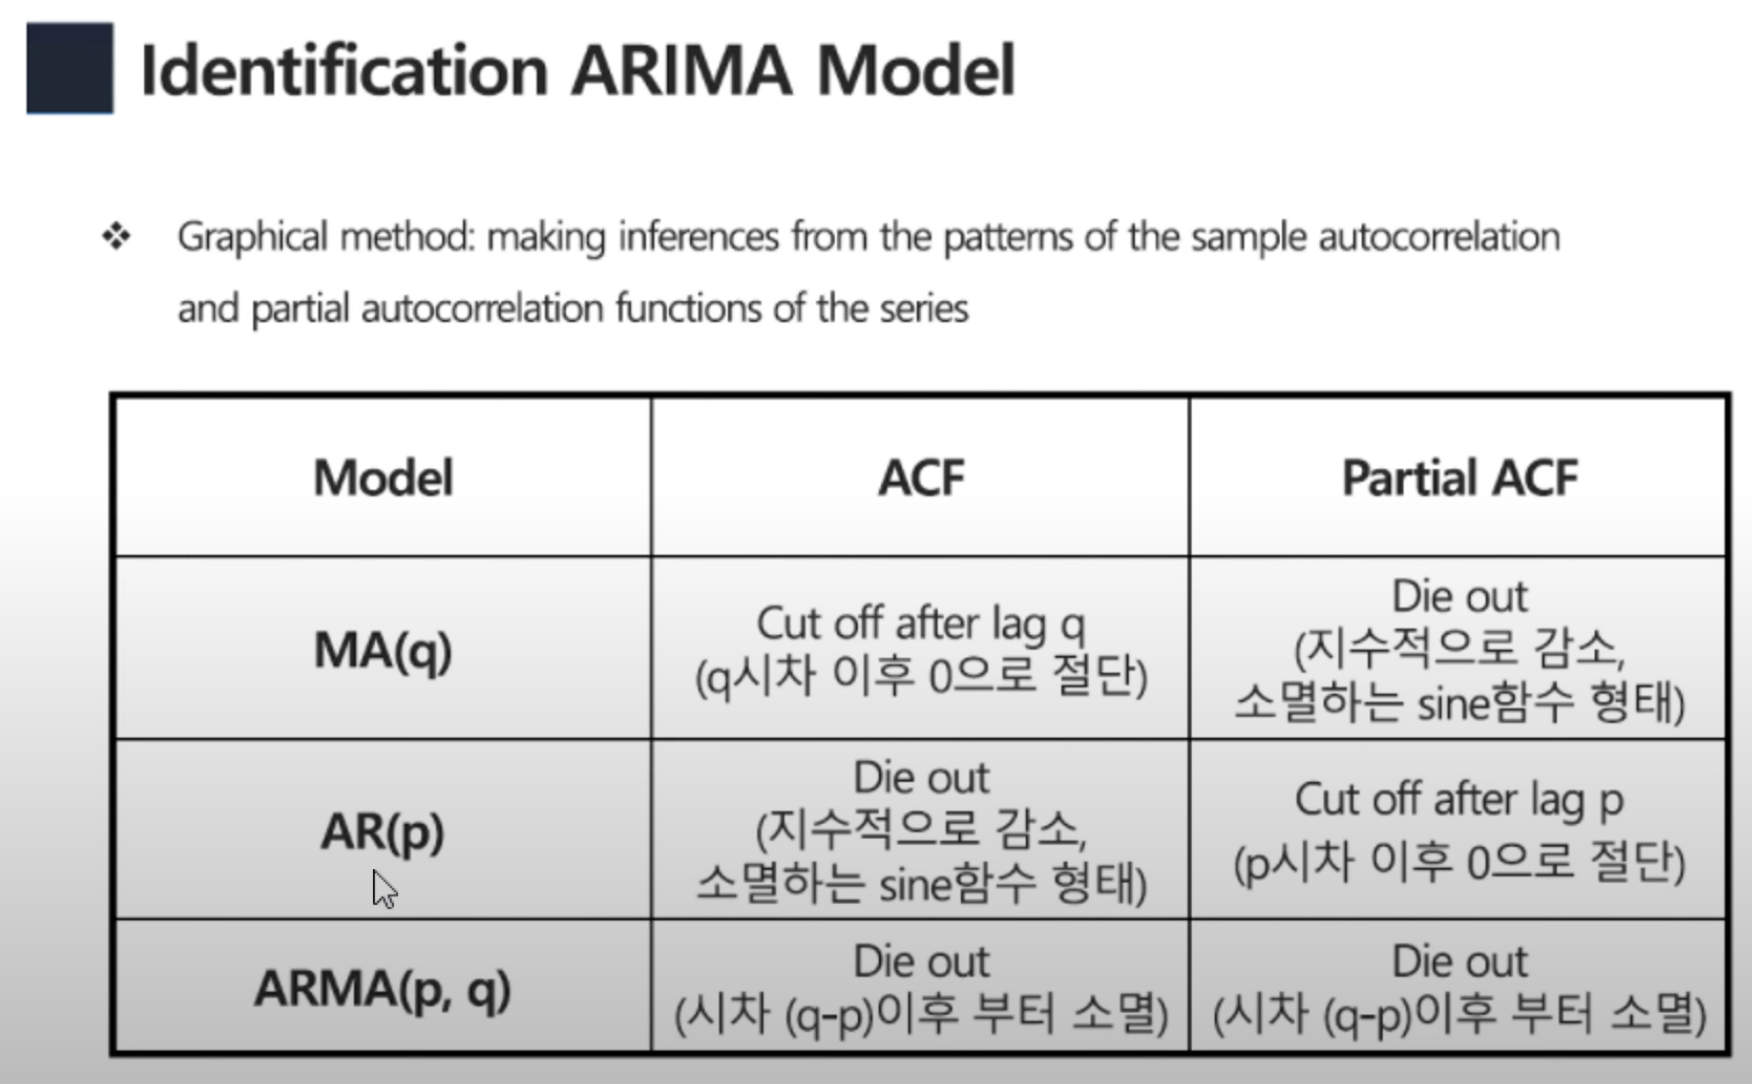

## Estimate Parameters

In [18]:
model = ARIMA(train_data.values, order=(1,1,0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -532.268
Date:                Fri, 04 Aug 2023   AIC                           1068.536
Time:                        11:05:06   BIC                           1074.008
Sample:                             0   HQIC                          1070.757
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2904      0.089      3.278      0.001       0.117       0.464
sigma2       664.7320     89.253      7.448      0.000     489.800     839.664
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                 3.25
Prob(Q):                              0.57   Prob(JB):                         0.20
Heteroskedasticity (H):               6.18   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Diagnosis Check - ARIMA

In [31]:
print('Examples of parameter combinations for seasonal ARIMA...')

p = range(0,3)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(p,d,q))

aic = [] 
for i in pdq:
    model = ARIMA(train_data.values, order=(i))
    model_fit = model.fit()
    print(f'ARIMA: {i} >> AIC: {round(model_fit.aic,2)}')
    aic.append(round(model_fit.aic,2))

Examples of parameter combinations for seasonal ARIMA...
ARIMA: (0, 1, 0) >> AIC: 1076.27
ARIMA: (0, 1, 1) >> AIC: 1063.65
ARIMA: (0, 1, 2) >> AIC: 1060.69
ARIMA: (1, 1, 0) >> AIC: 1068.54
ARIMA: (1, 1, 1) >> AIC: 1058.25
ARIMA: (1, 1, 2) >> AIC: 1057.33
ARIMA: (2, 1, 0) >> AIC: 1065.64
ARIMA: (2, 1, 1) >> AIC: 1058.65
ARIMA: (2, 1, 2) >> AIC: 1057.52


In [33]:
optimal = [(pdq[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[((1, 1, 2), 1057.33)]

In [37]:
model_opt = ARIMA(train_data.values, order=optimal[0][0])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -524.664
Date:                Fri, 04 Aug 2023   AIC                           1057.328
Time:                        11:52:50   BIC                           1068.272
Sample:                             0   HQIC                          1061.769
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5387      0.128      4.219      0.000       0.288       0.789
ma.L1         -0.2053      0.122     -1.688      0.091      -0.444       0.033
ma.L2         -0.5606      0.084     -6.647      0.000      -0.726      -0.395
sigma2       578.5728    105.827      5.467      0.000     371.155     785.991
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):                 4.81
Prob(Q):                              0.47   Prob(JB):                         0.09
Heteroskedasticity (H):               5.54   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Use Model to Forecast - ARIMA

In [60]:
forecast = model_opt_fit.get_forecast(len(test_data))
predicted_value = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.05)
predicted_ub = yhat_conf_int[:, 1]
predicted_lb = yhat_conf_int[:, 0]

predict_index = list(test_data.index)

r2 = r2_score(test_data, predicted_value)
r2

-0.11863065132411976

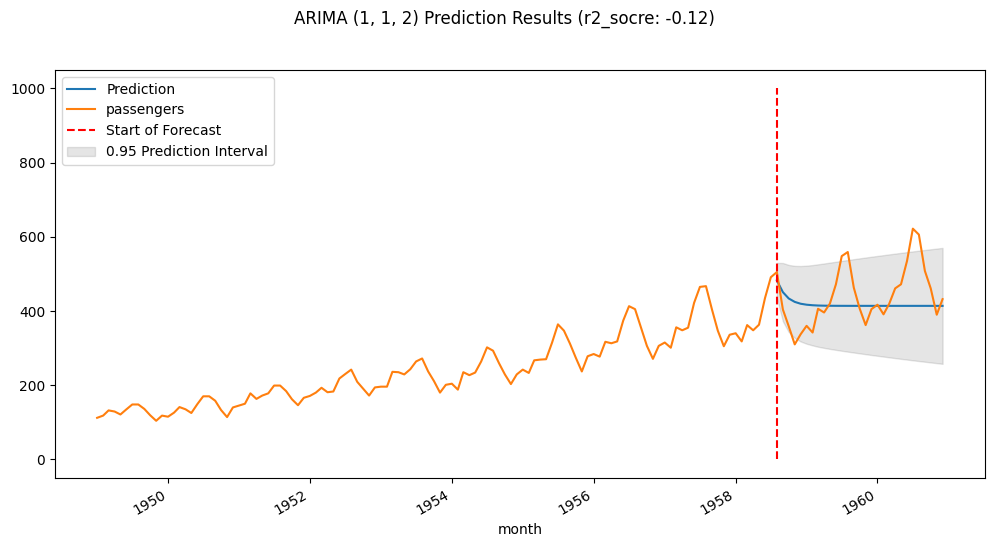

In [108]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(predict_index, predicted_value, label='Prediction')
data.plot(ax=ax)

ax.vlines('1958-08-01', 0, 1000, linestyle='--', color='r', label='Start of Forecast')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {optimal[0][0]} Prediction Results (r2_socre: {round(r2,2)})')
plt.show()

## Diagnosis Check - SARIMA

In [112]:
print('Examples of parameter combinations for Seasonal ARIMA')
p = range(0,3)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(p,d,q))
rang_month = 12
seasonal_pdq = [(x[0], x[0], x[0], rang_month) for x in list(itertools.product(p,d,q))]

aic = []
params = [] 
for i in pdq:
    for j in seasonal_pdq:
        try:
            model = SARIMAX(train_data.values, order=(i), seasonal_order=(j))
            model_fit = model.fit(disp=False) # verbose(로그) 제거 
            print(f'SARIMA: {i}/{j} >> AIC: {round(model_fit.aic,2)}')
            aic.append(round(model_fit.aic,2))
            params.append((i,j))
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA
SARIMA: (0, 1, 0)/(0, 0, 0, 12) >> AIC: 1076.27
SARIMA: (0, 1, 0)/(0, 0, 0, 12) >> AIC: 1076.27
SARIMA: (0, 1, 0)/(0, 0, 0, 12) >> AIC: 1076.27
SARIMA: (0, 1, 0)/(1, 1, 1, 12) >> AIC: 758.92
SARIMA: (0, 1, 0)/(1, 1, 1, 12) >> AIC: 758.92
SARIMA: (0, 1, 0)/(1, 1, 1, 12) >> AIC: 758.92


/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (0, 1, 0)/(2, 2, 2, 12) >> AIC: 688.41


/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (0, 1, 0)/(2, 2, 2, 12) >> AIC: 688.41


/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (0, 1, 0)/(2, 2, 2, 12) >> AIC: 688.41
SARIMA: (0, 1, 1)/(0, 0, 0, 12) >> AIC: 1063.65
SARIMA: (0, 1, 1)/(0, 0, 0, 12) >> AIC: 1063.65
SARIMA: (0, 1, 1)/(0, 0, 0, 12) >> AIC: 1063.65
SARIMA: (0, 1, 1)/(1, 1, 1, 12) >> AIC: 758.11
SARIMA: (0, 1, 1)/(1, 1, 1, 12) >> AIC: 758.11
SARIMA: (0, 1, 1)/(1, 1, 1, 12) >> AIC: 758.11


/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (0, 1, 1)/(2, 2, 2, 12) >> AIC: 684.23


/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (0, 1, 1)/(2, 2, 2, 12) >> AIC: 684.23


/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (0, 1, 1)/(2, 2, 2, 12) >> AIC: 684.23
SARIMA: (0, 1, 2)/(0, 0, 0, 12) >> AIC: 1060.69
SARIMA: (0, 1, 2)/(0, 0, 0, 12) >> AIC: 1060.69
SARIMA: (0, 1, 2)/(0, 0, 0, 12) >> AIC: 1060.69
SARIMA: (0, 1, 2)/(1, 1, 1, 12) >> AIC: 759.75
SARIMA: (0, 1, 2)/(1, 1, 1, 12) >> AIC: 759.75
SARIMA: (0, 1, 2)/(1, 1, 1, 12) >> AIC: 759.75


/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (0, 1, 2)/(2, 2, 2, 12) >> AIC: 686.1


/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (0, 1, 2)/(2, 2, 2, 12) >> AIC: 686.1


/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (0, 1, 2)/(2, 2, 2, 12) >> AIC: 686.1
SARIMA: (1, 1, 0)/(0, 0, 0, 12) >> AIC: 1068.54
SARIMA: (1, 1, 0)/(0, 0, 0, 12) >> AIC: 1068.54
SARIMA: (1, 1, 0)/(0, 0, 0, 12) >> AIC: 1068.54
SARIMA: (1, 1, 0)/(1, 1, 1, 12) >> AIC: 757.65
SARIMA: (1, 1, 0)/(1, 1, 1, 12) >> AIC: 757.65
SARIMA: (1, 1, 0)/(1, 1, 1, 12) >> AIC: 757.65


/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (1, 1, 0)/(2, 2, 2, 12) >> AIC: 683.65


/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (1, 1, 0)/(2, 2, 2, 12) >> AIC: 683.65


/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (1, 1, 0)/(2, 2, 2, 12) >> AIC: 683.65
SARIMA: (1, 1, 1)/(0, 0, 0, 12) >> AIC: 1058.25
SARIMA: (1, 1, 1)/(0, 0, 0, 12) >> AIC: 1058.25
SARIMA: (1, 1, 1)/(0, 0, 0, 12) >> AIC: 1058.25
SARIMA: (1, 1, 1)/(1, 1, 1, 12) >> AIC: 758.26
SARIMA: (1, 1, 1)/(1, 1, 1, 12) >> AIC: 758.26
SARIMA: (1, 1, 1)/(1, 1, 1, 12) >> AIC: 758.26


/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (1, 1, 1)/(2, 2, 2, 12) >> AIC: 685.4


/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (1, 1, 1)/(2, 2, 2, 12) >> AIC: 685.4


/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (1, 1, 1)/(2, 2, 2, 12) >> AIC: 685.4
SARIMA: (1, 1, 2)/(0, 0, 0, 12) >> AIC: 1057.33
SARIMA: (1, 1, 2)/(0, 0, 0, 12) >> AIC: 1057.33
SARIMA: (1, 1, 2)/(0, 0, 0, 12) >> AIC: 1057.33
SARIMA: (1, 1, 2)/(1, 1, 1, 12) >> AIC: 760.1
SARIMA: (1, 1, 2)/(1, 1, 1, 12) >> AIC: 760.1
SARIMA: (1, 1, 2)/(1, 1, 1, 12) >> AIC: 760.1


/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (1, 1, 2)/(2, 2, 2, 12) >> AIC: 687.33


/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (1, 1, 2)/(2, 2, 2, 12) >> AIC: 687.33


/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (1, 1, 2)/(2, 2, 2, 12) >> AIC: 687.33
SARIMA: (2, 1, 0)/(0, 0, 0, 12) >> AIC: 1065.64
SARIMA: (2, 1, 0)/(0, 0, 0, 12) >> AIC: 1065.64
SARIMA: (2, 1, 0)/(0, 0, 0, 12) >> AIC: 1065.64
SARIMA: (2, 1, 0)/(1, 1, 1, 12) >> AIC: 758.86
SARIMA: (2, 1, 0)/(1, 1, 1, 12) >> AIC: 758.86
SARIMA: (2, 1, 0)/(1, 1, 1, 12) >> AIC: 758.86


/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 0)/(2, 2, 2, 12) >> AIC: 685.53


/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 0)/(2, 2, 2, 12) >> AIC: 685.53


/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 0)/(2, 2, 2, 12) >> AIC: 685.53
SARIMA: (2, 1, 1)/(0, 0, 0, 12) >> AIC: 1058.65
SARIMA: (2, 1, 1)/(0, 0, 0, 12) >> AIC: 1058.65
SARIMA: (2, 1, 1)/(0, 0, 0, 12) >> AIC: 1058.65


/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA: (2, 1, 1)/(1, 1, 1, 12) >> AIC: 760.18
SARIMA: (2, 1, 1)/(1, 1, 1, 12) >> AIC: 760.18
SARIMA: (2, 1, 1)/(1, 1, 1, 12) >> AIC: 760.18


/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 1)/(2, 2, 2, 12) >> AIC: 687.37


/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 1)/(2, 2, 2, 12) >> AIC: 687.37


/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 1)/(2, 2, 2, 12) >> AIC: 687.37
SARIMA: (2, 1, 2)/(0, 0, 0, 12) >> AIC: 1057.52
SARIMA: (2, 1, 2)/(0, 0, 0, 12) >> AIC: 1057.52
SARIMA: (2, 1, 2)/(0, 0, 0, 12) >> AIC: 1057.52
SARIMA: (2, 1, 2)/(1, 1, 1, 12) >> AIC: 757.71
SARIMA: (2, 1, 2)/(1, 1, 1, 12) >> AIC: 757.71
SARIMA: (2, 1, 2)/(1, 1, 1, 12) >> AIC: 757.71


/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 2)/(2, 2, 2, 12) >> AIC: 688.1


/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 2)/(2, 2, 2, 12) >> AIC: 688.1


/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 2)/(2, 2, 2, 12) >> AIC: 688.1


In [113]:
optimal = [(params[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[(((1, 1, 0), (2, 2, 2, 12)), 683.65),
 (((1, 1, 0), (2, 2, 2, 12)), 683.65),
 (((1, 1, 0), (2, 2, 2, 12)), 683.65)]

In [114]:
model_opt = SARIMAX(train_data.values, order=optimal[0][0][0], seasonal_order=optimal[0][0][1])
model_opt_fit = model_opt.fit(disp=False)

model_opt_fit.summary()

/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(2, 2, [1, 2], 12)   Log Likelihood                -335.827
Date:                                 Fri, 04 Aug 2023   AIC                            683.654
Time:                                         15:42:26   BIC                            698.653
Sample:                                              0   HQIC                           689.702
                                                 - 115                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2868      0.101     -2.853      0.004      -0.484      -0.090
ar.S.L12       0.4288      1.589      0.270      0.787      -2.686       3.544
ar.S.L24       0.0033      0.385      0.009      0.993      -0.750       0.757
ma.S.L12      -1.7571      6.201     -0.283      0.777     -13.911      10.397
ma.S.L24       0.9204      6.565      0.140      0.888     -11.946      13.787
sigma2        69.1864    353.033      0.196      0.845    -622.747     761.119
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.44
Prob(Q):                              0.99   Prob(JB):                         0.49
Heteroskedasticity (H):               0.53   Skew:                             0.30
Prob(H) (two-sided):                  0.08   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [129]:
prediction = model_opt_fit.get_forecast(len(test_data))
predicted_value = prediction.predicted_mean
conf_int_value = prediction.conf_int(alpha=0.05)
predicted_ub = conf_int_value[:, 1]
predicted_lb = conf_int_value[:, 0]

predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)
r2

0.8128068749837907

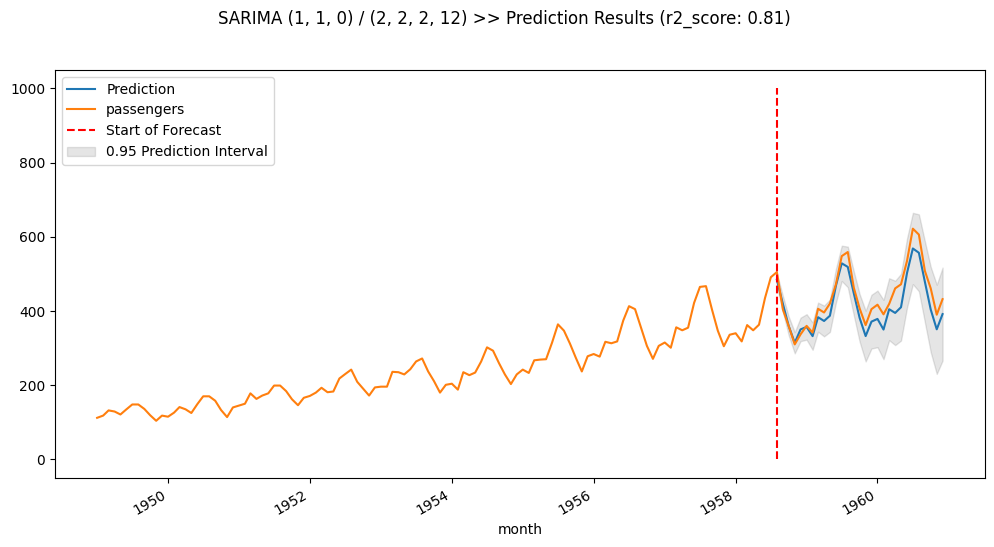

In [131]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(predict_index, predicted_value, label='Prediction')
data.plot(ax=ax)

ax.vlines('1958-08-01', 0, 1000, linestyle='--', color='r', label='Start of Forecast')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {optimal[0][0][0]} / {optimal[0][0][1]} >> Prediction Results (r2_score: {round(r2, 2)})')
plt.show()

# 3 Auto_arima

In [132]:
auto_arima_model = auto_arima(train_data, start_p=1, start_q=1, max_p=3, max_q=3, m=12, seasonal=True,
                                d=1, D=1, max_P=3, max_Q=3, trace=True, error_action='ignore', suppress_warnings=True, stepwise=False)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=757.826, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=756.988, Time=0.16 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=758.826, Time=0.56 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=758.186, Time=0.51 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=756.959, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=758.922, Time=0.09 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.43 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=754.685, Time=1.24 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=758.869, Time=0.23 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=760.726, Time=0.42 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=1.31 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=756.686, Time=2.01 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=759.643, Time=0.26 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=1.89 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=756.688, Time=2.61 sec
 ARIMA(0,1,1)(0,1,0)[1

In [133]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                          y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(1, 1, [1, 2, 3], 12)   Log Likelihood                -370.278
Date:                                    Fri, 04 Aug 2023   AIC                            752.557
Time:                                            16:32:34   BIC                            768.307
Sample:                                        01-01-1949   HQIC                           758.934
                                             - 07-01-1958                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2218      0.093     -2.388      0.017      -0.404      -0.040
ar.S.L12       0.9288      0.275      3.374      0.001       0.389       1.468
ma.S.L12      -1.2065      0.448     -2.692      0.007      -2.085      -0.328
ma.S.L24       0.2771      0.174      1.596      0.111      -0.063       0.618
ma.S.L36       0.1251      0.164      0.765      0.444      -0.195       0.446
sigma2        75.0386     19.073      3.934      0.000      37.656     112.421
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.50
Prob(Q):                              0.91   Prob(JB):                         0.29
Heteroskedasticity (H):               1.05   Skew:                             0.37
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [140]:
prediction = auto_arima_model.predict(len(test_data), return_conf_int=True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:, 1]
predicted_lb = prediction[1][:, 0]

predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)
r2

0.8836220214688464

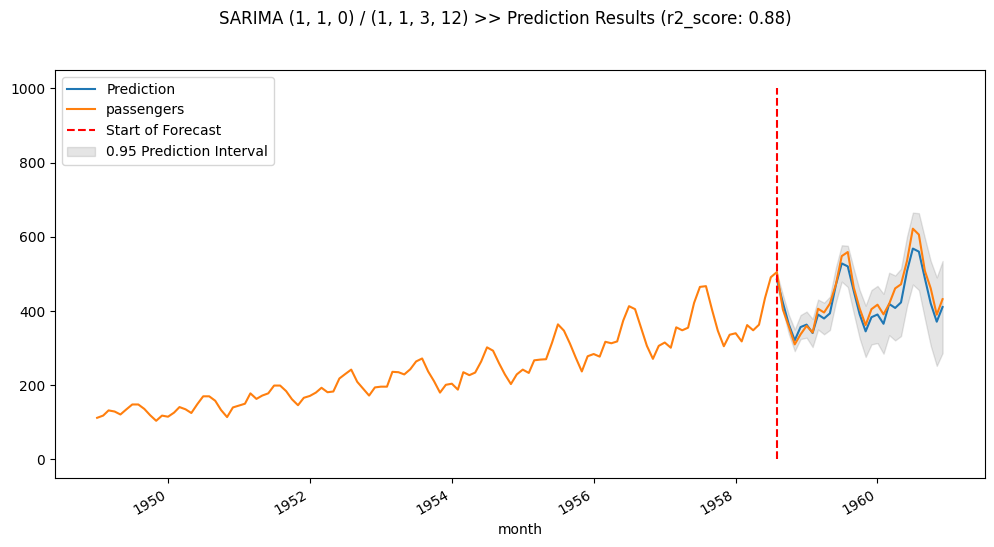

In [142]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(predict_index, predicted_value, label='Prediction')
data.plot(ax=ax)

ax.vlines('1958-08-01', 0, 1000, linestyle='--', color='r', label='Start of Forecast')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {auto_arima_model.order} / {auto_arima_model.seasonal_order} >> Prediction Results (r2_score: {round(r2, 2)})')
plt.show()

# 주식

In [143]:
def get_code(df, name):
    code = df.query("name=='{}'".format(name))['code'].to_string(index=False)
    code = code.strip()
    return code 

In [164]:
code_data = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]
code_data = code_data.dropna()
code_data['종목코드'] = code_data['종목코드'].apply(int) #.astype(str)
code_data.head()

,회사명,종목코드,업종,주요제품,상장일,결산월,대표자명,홈페이지,지역
0,AJ네트웍스,95570,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,손삼달,http://www.ajnet.co.kr,서울특별시
1,BNK금융지주,138930,기타 금융업,금융지주회사,2011-03-30,12월,빈대인,http://www.bnkfg.com,부산광역시
2,DSR,155660,1차 비철금속 제조업,합섬섬유로프,2013-05-15,12월,홍석빈,http://www.dsr.com,부산광역시
4,HDC현대산업개발,294870,건물 건설업,"외주주택, 자체공사, 일반건축, 토목 등",2018-06-12,12월,"최익훈, 정익희, 김회언 (각자 대표이사)",http://www.hdc-dvp.com,서울특별시
5,HD한국조선해양,9540,기타 금융업,"선박,해양구조물,엔진,펌프 전동기,중전기,중장비 제조/자동창고,물류시스템",1999-08-24,12월,"가삼현, 정기선 (각자 대표이사)",http://www.ksoe.co.kr,경기도


In [165]:
code_data = code_data[['회사명','종목코드']]
code_data = code_data.rename(columns={
    '회사명':'name', '종목코드':'code'
})
code_data.code = code_data.code.map('{:06d}'.format)
code_data.head()

,name,code
0,AJ네트웍스,095570
1,BNK금융지주,138930
2,DSR,155660
4,HDC현대산업개발,294870
5,HD한국조선해양,009540


In [168]:
stock_code

'011070.KS'

In [169]:
stock_code = get_code(code_data, 'LG이노텍')
# stock_code = stock_code +'.KS'
stock_data = pdr.get_data_yahoo(int(stock_code))

stock_data.head()

TypeError: string indices must be integers, not 'str'